In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import yaml
import ast
from tqdm import tqdm
from datetime import datetime
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import json

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
train.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
train.iloc[767]["tagline"]

'Come and Get Some!'

In [5]:
miss = train.isnull().sum()
miss= miss[miss > 0]
miss.sort_values(inplace=True)
miss

poster_path                 1
runtime                     2
genres                      7
overview                    8
cast                       13
crew                       16
spoken_languages           20
production_countries       55
production_companies      156
Keywords                  276
tagline                   597
homepage                 2054
belongs_to_collection    2396
dtype: int64

In [6]:
# get lengths of text columns
columns = ['original_title', 'title', 'overview', 'tagline']
for col in columns:
    new_col = col + '_len'
    train[new_col] = train[col].apply(lambda x: 0 if x is np.nan else len(x))
    test[new_col] = test[col].apply(lambda x: 0 if x is np.nan else len(x))

# drop ID/URL/text columns
columns.extend(['homepage', 'imdb_id', 'poster_path', 'belongs_to_collection'])

train.drop(columns, axis=1, inplace=True)
test.drop(columns, axis=1, inplace=True)

In [7]:
#Alternate way to drop features using for loop
# train = train[[i for i in train.columns if i not in ["id", "belongs_to_collection", "overview", "poster_path","homepage", "title","original_title","Keywords"]]]    
# test = test[[i for i in test.columns if i not in ["id", "belongs_to_collection", "overview", "poster_path", "tagline","homepage", "title","original_title","Keywords"]]]    

In [8]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],test.shape[1]))

The train data has 3000 rows and 19 columns
The test data has 4398 rows and 18 columns


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


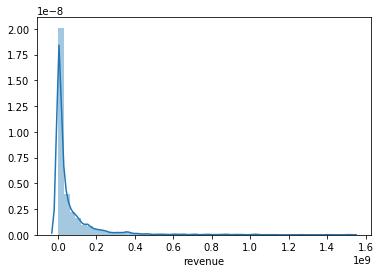

In [9]:

#Creating Distribution Plot
sns.distplot(train["revenue"])

The skewness of target is 0.005468456321668449


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


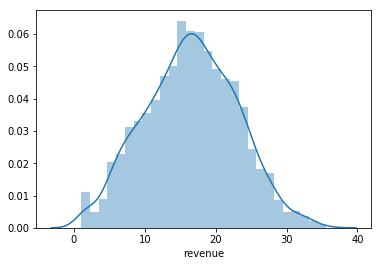

In [10]:
#Determining Skewness
target= np.power(train['revenue'], 0.169)
print ("The skewness of target is {}".format(target.skew()))
sns.distplot(target)


In [11]:
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print("There are {} numeric features and {} categorical features".format(numeric_data.shape[1], cat_data.shape[1]))

There are 9 numeric features and 10 categorical features


In [12]:
train.status = train.status.fillna("released")
test.status = test.status.fillna("released")

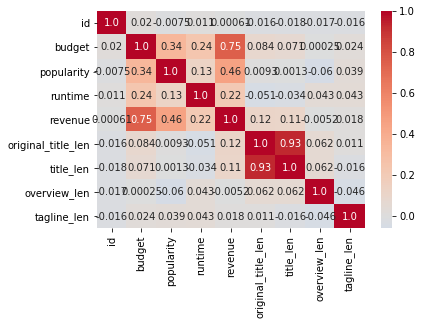

In [13]:
corr= numeric_data.corr()
sns.heatmap(corr, annot=True, fmt='.2', center=0.0, cmap='coolwarm')

In [14]:
print (corr['revenue'].sort_values(ascending=False)[:], '\n')

revenue               1.000000
budget                0.752965
popularity            0.461460
runtime               0.216380
original_title_len    0.117582
title_len             0.109664
tagline_len           0.018118
id                    0.000610
overview_len         -0.005188
Name: revenue, dtype: float64 



In [15]:
cat_data.describe()

,genres,original_language,production_companies,production_countries,release_date,spoken_languages,status,Keywords,cast,crew
count,2993,3000,2844,2945,3000,2980,3000,2724,2987,2984
unique,872,36,2383,321,2398,401,2,2648,2975,2984
top,"[{'id': 18, 'name': 'Drama'}]",en,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '538f48c8c3a3680d7500021b', 'de..."
freq,266,2575,51,1752,5,1817,2996,27,13,1


In [16]:
print(train[["original_language", "revenue"]].groupby(['original_language'], as_index=False).mean().sort_values(by='revenue', ascending=False))

   original_language       revenue
7                 en  7.466591e+07
35                zh  7.037637e+07
32                tr  5.166341e+07
17                ja  3.065180e+07
2                 cn  2.977289e+07
13                hi  2.534637e+07
5                 de  2.053090e+07
11                fr  1.713257e+07
16                it  1.641513e+07
24                pl  1.501083e+07
30                ta  1.470625e+07
18                ko  1.377670e+07
4                 da  1.175709e+07
29                sv  1.163051e+07
12                he  1.112585e+07
25                pt  1.087902e+07
8                 es  8.564790e+06
31                te  8.320425e+06
6                 el  8.000000e+06
27                ru  6.929453e+06
20                mr  4.400000e+06
21                nb  4.159678e+06
15                id  2.627209e+06
22                nl  1.959667e+06
10                fi  1.471932e+06
0                 ar  1.347747e+06
19                ml  1.315000e+06
23                no

In [17]:
sp_pivot= train.pivot_table(index='original_language', values='revenue', aggfunc=np.mean).sort_values(by= 'revenue', ascending=False)
sp_pivot

,revenue
original_language,
en,7.466591e+07
zh,7.037637e+07
tr,5.166341e+07
ja,3.065180e+07
cn,2.977289e+07
hi,2.534637e+07
de,2.053090e+07
fr,1.713257e+07
it,1.641513e+07


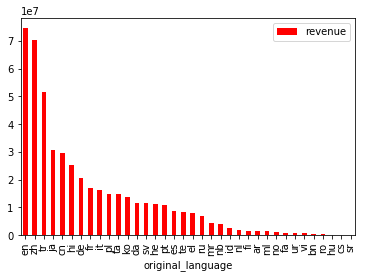

In [18]:
sp_pivot.plot(kind='bar', color='red')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:2923: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

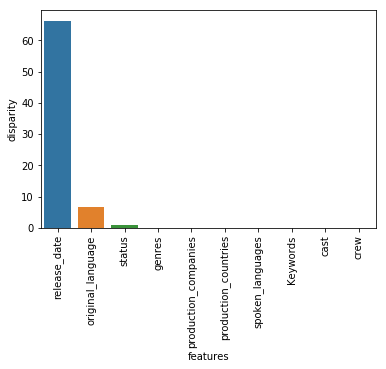

In [19]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['revenue'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['revenue'] = train.revenue.values
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


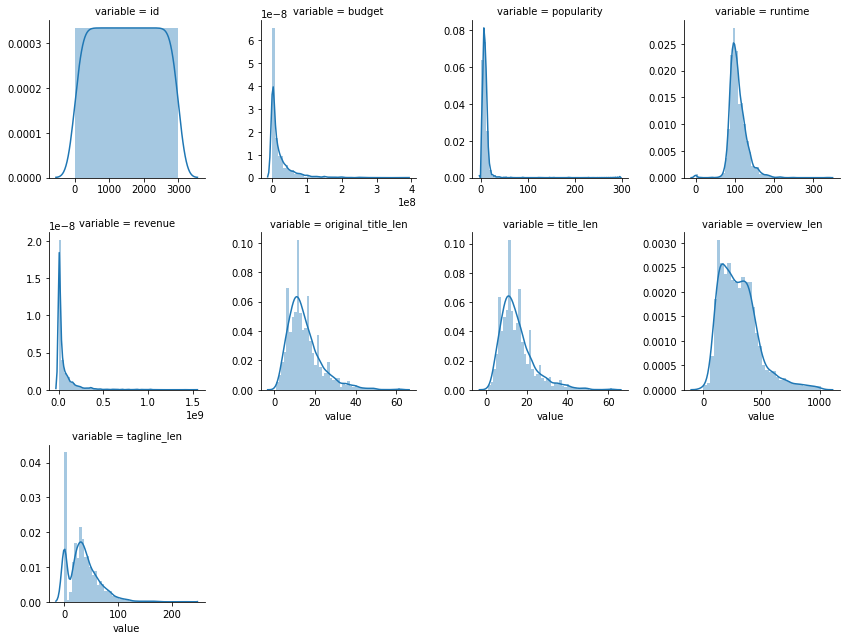

In [20]:
#create numeric plots
num = [f for f in train.columns if train.dtypes[f] != 'object']
nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


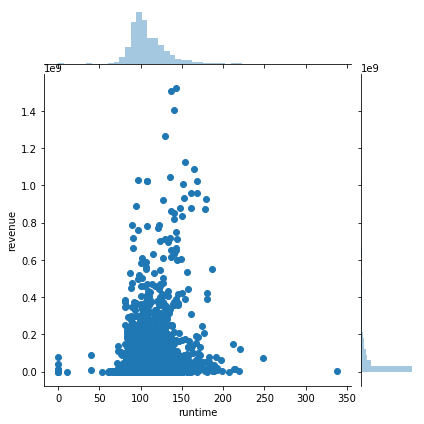

In [21]:
#Creating Jointplot
sns.jointplot(x=train['runtime'], y=train['revenue'])

In [22]:
d1=dict.fromkeys(set(train["original_language"].values),0 )
for i in train["original_language"].values:
    d1[i]+=1

In [23]:
train.loc[train.release_date.isnull(), 'release_date'] = train.release_date.mode()[0]
test.loc[test.release_date.isnull(), 'release_date'] = test.release_date.mode()[0]

In [24]:
train["runtime"].fillna(train["runtime"].mean, inplace=True)
test["runtime"].fillna(test["runtime"].mean, inplace=True)

train["spoken_languages"].fillna("en", inplace=True)
test["spoken_languages"].fillna("en", inplace=True)

train = train.drop(["Keywords"], axis = 1)
test = test.drop(["Keywords"], axis = 1)

In [25]:
def expand_release_date(df):
    df.release_date = pd.to_datetime(df.release_date)

    df['release_year'] = df.release_date.dt.year
    df['release_year'] = df.release_year.apply(lambda x: x-100 if x > 2020 else x)
    
    df['release_month'] = df.release_date.dt.month
    df['release_day'] = df.release_date.dt.dayofweek
    df['release_quarter'] = df.release_date.dt.quarter
    
    return df

train = expand_release_date(train)
test = expand_release_date(test)

In [26]:
train["genres"].fillna("[{'id': 18, 'name': 'Drama'}]", inplace=True)
test["genres"].fillna("[{'id': 18, 'name': 'Drama'}]", inplace=True)
train["production_countries"].fillna("[{'iso_3166_1': 'US', 'name': 'United States of America'}]"
, inplace=True)
test["production_countries"].fillna("[{'iso_3166_1': 'US', 'name': 'United States of America'}]"
, inplace=True)
train["production_companies"].fillna("[{'name': 'Paramount Pictures', 'id': 4}]"
, inplace=True)
test["production_companies"].fillna("[{'name': 'Paramount Pictures', 'id': 4}]"
, inplace=True)

In [27]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


29     273
30     236
59     192
63     190
93     172
62     125
91     121
64     120
60      95
61      95
90      89
95      89
94      83
92      74
120     56
124     52
123     50
58      46
35      44
96      38
103     38
89      36
66      32
125     29
88      28
102     27
97      27
129     26
121     26
99      25
135     22
126     22
65      22
100     21
32      19
153     17
101     16
127     16
122     15
70      14
134     13
69      13
132     11
128     11
154     11
131     10
67       9
161      9
157      9
72       9
      ... 
31       8
40       8
73       8
137      8
136      8
156      8
130      7
159      6
150      6
106      5
163      5
155      5
133      5
98       4
167      4
158      4
160      4
165      4
105      4
119      3
164      3
166      3
34       3
169      3
152      3
196      3
104      3
139      2
189      2
187      2
194      2
151      2
197      2
190      2
170      2
68       2
162      2
199      1
230      1
138      1

In [28]:
def conj(j):
    return [i["id"] for i in eval(j)]
train["genres"]=train["genres"].apply(lambda l: conj(l))
test["genres"]=test["genres"].apply(lambda l: conj(l))

In [29]:
def conj(j):
    return [i["name"] for i in eval(j)]
train["production_companies"]=train["production_companies"].apply(lambda l: conj(l))
test["production_companies"]=test["production_companies"].apply(lambda l: conj(l))

In [30]:
def conj(j):
    return [i["iso_3166_1"] for i in eval(j)]
train["production_countries"]=train["production_countries"].apply(lambda l: conj(l))
test["production_countries"]=test["production_countries"].apply(lambda l: conj(l))

In [31]:
def conj(j):
    if pd.isnull(j):
        return np.nan
    return [i["name"] for i in eval(str(j))]
train["cast"]=train["cast"].apply(lambda l: conj(l))
test["cast"]=test["cast"].apply(lambda l: conj(l))

In [32]:
def conj(j):
    if pd.isnull(j):
        return np.nan
    return [i["name"] for i in eval(str(j))]
train["crew"]=train["crew"].apply(lambda l: conj(l))
test["crew"]=test["crew"].apply(lambda l: conj(l))

In [33]:
from collections import Counter
list1= list()
for i in train.dropna().cast:
    if i:
        list1.extend(i)

In [34]:
from collections import Counter
tlist1= list()
for i in test.dropna().cast:
    if i:
        tlist1.extend(i)

In [35]:
# q = Counter([i[1]for i in Counter(list1).most_common()]).most_common()

In [36]:
train=train.dropna(axis=0)
train.cast = train.cast.apply(lambda y: np.nan if len(y)==0 else y)

In [37]:
test=test.dropna(axis=0)
test.cast = test.cast.apply(lambda y: np.nan if len(y)==0 else y)

In [38]:
train=train.dropna(axis=0)
test=test.dropna(axis=0)

In [39]:
list2=[]
for i,j in zip(train["revenue"],train["cast"]):
    for k in range(len(j)):
        list2.append(i)

In [40]:
# tyu=[len(i) for i in train["cast"]]
# tyu.index(0)

In [41]:
app_count = dict(Counter(list1))
list3=list(app_count.values())
rate=dict([(k,i/j) for i,j,k in zip(list2,list3,app_count.keys())])
def sume(l):
    sum1=0
    for i in l:
        sum1+=rate[i]
    return sum1/len(l)
train["cast_rev"]=train["cast"].apply(lambda l : sume(l))

In [42]:
col= [ "id","original_language", "spoken_languages", "title_len", "runtime"]
for i in col:
    train.drop(i, axis=1, inplace=True)

In [43]:
col= [ "id","original_language", "spoken_languages", "title_len", "runtime"]
for i in col:
    test.drop(i, axis=1, inplace=True)

In [44]:
# lo=list(set(np.hstack(train['production_companies'])))
# enco=[]
# for i in train["production_companies"]:
#     if type(i)== list:
#         en=np.zeros((len(lo),),dtype="int")
#         for j in i:
#             en[lo.index(j)]=1
#         enco.append(list(en))
#     else :
#         enco.append(i)

train["cast_rev"]/=min(train["cast_rev"])
# test["cast_rev"]/=min(test["cast_rev"])

In [45]:
train["cast"]

0       [Rob Corddry, Craig Robinson, Clark Duke, Adam...
1       [Anne Hathaway, Julie Andrews, H√©ctor Elizond...
2       [Miles Teller, J.K. Simmons, Melissa Benoist, ...
3       [Vidya Balan, Nawazuddin Siddiqui, Parambrata ...
4       [Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...
5       [Scott Grimes, Tom Bosley, Rickie Lee Jones, J...
6       [Jeffrey Dean Morgan, Natasha Calis, Madison D...
7       [Samir Khader, Josh Rushing, George W. Bush, H...
8       [Tim Curry, Kevin Bishop, Jennifer Saunders, B...
9       [Bob Balaban, Christopher Guest, John Michael ...
10      [Sylvester Stallone, Talia Shire, Burt Young, ...
11      [Robert Carradine, Curtis Armstrong, Larry B. ...
12      [Kevin Spacey, Annette Bening, Thora Birch, We...
13      [John Travolta, Uma Thurman, Vince Vaughn, Ced...
14      [Tom Cruise, Colin Farrell, Samantha Morton, M...
15      [Nikola Rakoƒçeviƒá, Viktor Saviƒá, Nata≈°a Ta...
16      [Rachel McAdams, Cillian Murphy, Brian Cox, Ja...
17      [Ralph

In [46]:
train["cast_no"]=train["cast"].apply(lambda l: np.max([app_count[i] for i in l]))

In [47]:
test["cast"]

0       [Craig Blair, Emily Bauer, Sarah Natochenny, I...
1       [Allison Hayes, William Hudson, Yvette Vickers...
2       [Meg Ryan, Matthew Broderick, Kelly Preston, T...
3       [Lubna Azabal, M√©lissa D√©sormeaux-Poulin, Ma...
4       [Dennis Hopper, Peter Bart, Warren Beatty, Car...
5       [Jayce Bartok, Amie Carey, Nicky Katt, Ajay Na...
6       [Sophie Rois, Sebastian Schipper, Devid Stries...
7       [Jim Cummings, Nikita Hopkins, Ken Sansom, Joh...
8       [Anne Hathaway, James McAvoy, Julie Walters, J...
9       [Tom Hanks, Tim Allen, Joan Cusack, Kelsey Gra...
10      [Edward Furlong, Daniel Franzese, Andrew Keega...
11      [Karidja Tour√©, Assa Sylla, Lindsay Karamoh, ...
12      [N!xau, Michael Thys, Marius Weyers, Sandra Pr...
13      [Victor Rasuk, Judy Marte, Melonie Diaz, Altag...
14      [Rachel Weisz, Adrien Brody, Mark Ruffalo, Rin...
15      [Michael Sheen, Maria Bello, Alan Tudyk, Moon ...
16      [John Cusack, Lizzy Caplan, Rob Corddry, Craig...
17      [Johnn

In [49]:
# test["cast_no"]=test["cast"].apply(lambda l: np.max([app_count[i] for i in l]))

In [50]:
train=train.drop("cast",axis=1)
test=test.drop("cast",axis=1)

In [51]:
#This feature came out to be of less significance, therefore no need for doin this 
# lo1=list(set(np.hstack(train['genres'])))
# enco1=[]
# for i in train["genres"]:
#     if type(i)== list:
#         en=np.zeros((len(lo1),),dtype="int")
#         for j in i:
#             en[lo1.index(j)]=1
#         enco1.append(list(en))
#     else :
#         print(type(i))
#         enco1.append(i)

In [52]:
# train[["g"+str(i) for i in range(20)]]=pd.DataFrame(enco1,index=train.index)

In [53]:
train.drop("crew",axis=1,inplace=True)
test.drop("crew",axis=1,inplace=True)

In [54]:
train.drop("production_countries",axis=1,inplace=True)
test.drop("production_countries",axis=1,inplace=True)

In [55]:
train.drop(["genres","release_date"],axis=1,inplace=True)
test.drop(["genres","release_date"],axis=1,inplace=True)

In [56]:
from collections import Counter
list1= list()
for i in train.dropna().production_companies:
    if i:
        list1.extend(i)
train.production_companies = train.production_companies.apply(lambda y: np.nan if len(y)==0 else y)
train=train.dropna(axis=0)

In [57]:
from collections import Counter
tlist1= list()
for i in test.dropna().production_companies:
    if i:
        tlist1.extend(i)
test.production_companies = test.production_companies.apply(lambda y: np.nan if len(y)==0 else y)
test=test.dropna(axis=0)

In [58]:
app_count = dict(Counter(list1))

In [60]:
train["production_no"]=train["production_companies"].apply(lambda l: np.max([app_count[i] for i in l]))
# test["production_no"]=test["production_companies"].apply(lambda l: np.max([app_count[i] for i in l]))

In [61]:
train.drop("production_companies",axis=1,inplace=True)
test.drop("production_companies",axis=1,inplace=True)

In [62]:
ct = OneHotEncoder()
train["status"]=ct.fit_transform([train["status"]]).toarray()[0]
test["status"]=ct.fit_transform([test["status"]]).toarray()[0]

In [63]:
train.drop("status",axis=1,inplace=True)
test.drop("status",axis=1,inplace=True)

In [66]:
sc = StandardScaler()
scaled = sc.fit_transform(train.values)
df1=pd.DataFrame(scaled)
X = df1[[i for i in df1.columns if i != 2]].values
y = df1[2].values

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=0)

In [68]:
from sklearn.linear_model import LinearRegression
regressor= LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [69]:
y_pred1= regressor.predict(X_test)

In [71]:
def rmse(pred, actual):
    return np.sqrt(((pred-actual)**2).mean())

In [73]:
print("%.20f"%rmse(y_pred1, y_test))

0.67816475265219011703


In [74]:
from sklearn.metrics import r2_score
print("%.10f"%r2_score(y_test, y_pred1))

0.6092195895


In [76]:
from sklearn.ensemble import RandomForestRegressor 
regressor2= RandomForestRegressor(n_estimators= 400)
regressor2.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [77]:
y_pred2= regressor2.predict(X_test)

In [78]:
r2_score(y_test, y_pred2)

0.6033106716380103

In [79]:
rmse(y_pred2, y_test)

0.6832727174478195